In [ ]:
# Load the data from drive
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if not os.path.exists('/content/data'):
  os.symlink('/content/drive/MyDrive/Medical-Cost-Personal-Datasets', '/content/data')

In [ ]:
import tensorflow as tf
import joblib
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder , StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import Huber
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [ ]:
# GLOBAL VARIABLES
RANDOM_STATE = 42
test_size = 0.2

In [ ]:
# Read the data
df = pd.read_csv('/content/data/insurance.csv')

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# Converting charges to log nepe of charges
def convert(df):
  df = np.log1p(df)
  return df

In [ ]:
X = df.drop('charges', axis=1)
y = df['charges']

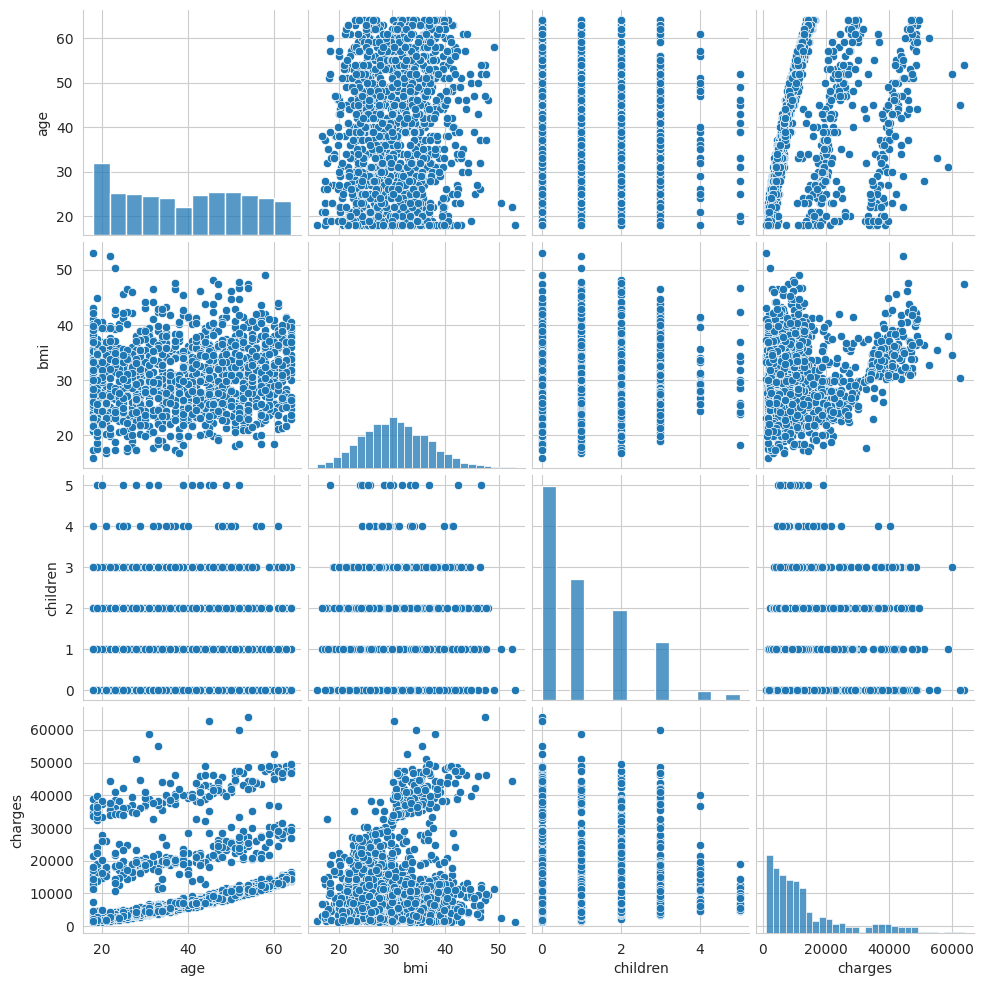

In [ ]:
sns.pairplot(df)
plt.show()

<Axes: xlabel='charges', ylabel='Count'>

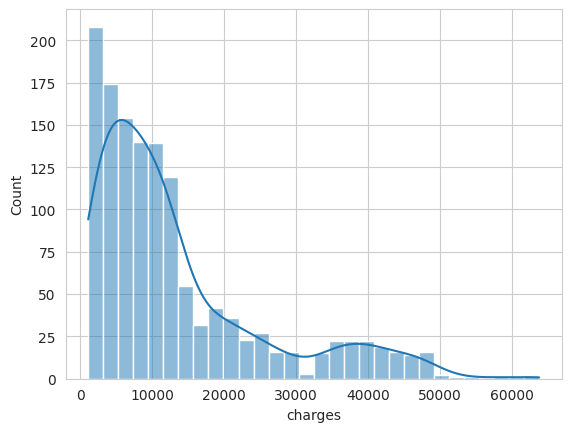

In [ ]:
sns.histplot(df['charges'], kde=True)

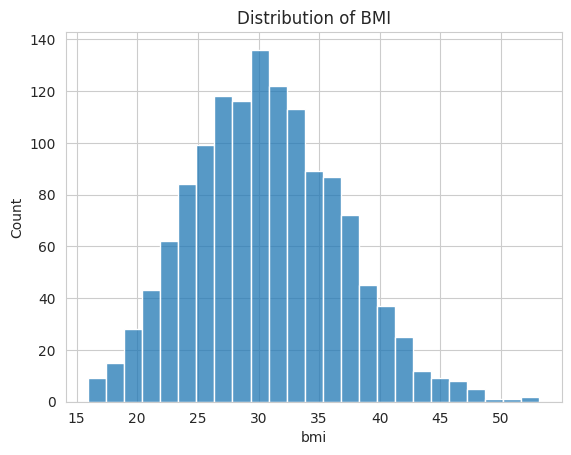

In [ ]:
sns.histplot(df['bmi'])
plt.title('Distribution of BMI')
plt.show()

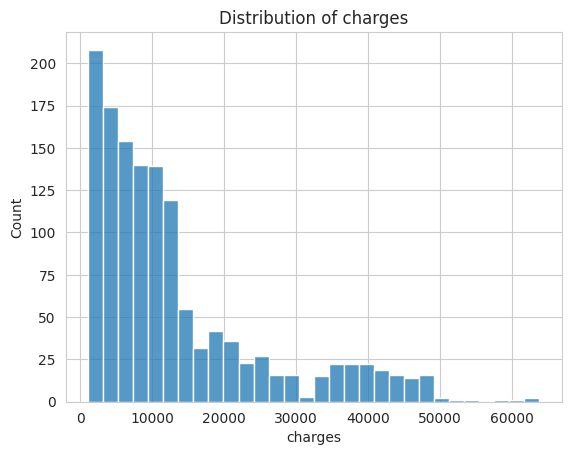

In [ ]:
sns.histplot(df['charges'])
plt.title('Distribution of charges')
plt.show()

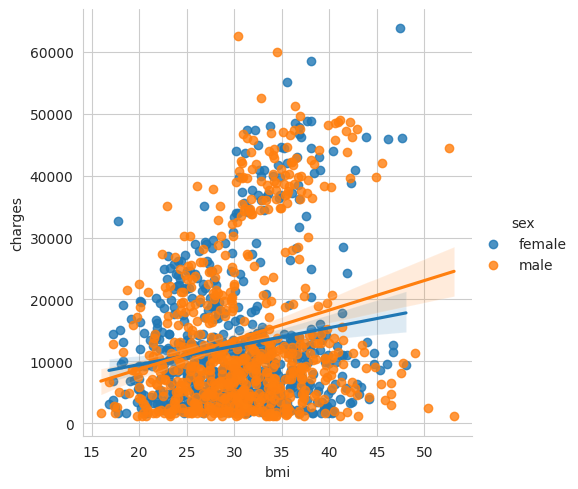

In [ ]:
# Inspect the correlation between age and charges
sns.set_style('whitegrid')
sns.lmplot(x='bmi', y='charges', data=df, hue='sex')
plt.show()

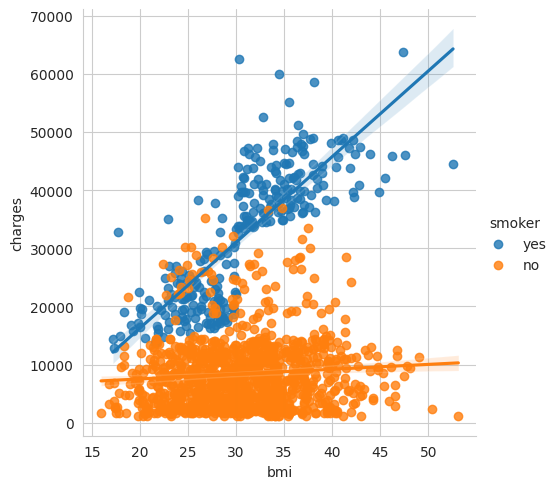

In [ ]:
# Inspect the correlation between smoking and charges
sns.set_style('whitegrid')
sns.lmplot(x='bmi', y='charges', data=df, hue='smoker')
plt.show()

In [ ]:
X.describe()

,age,bmi,children
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918
std,14.049960,6.098187,1.205493
min,18.000000,15.960000,0.000000
25%,27.000000,26.296250,0.000000
50%,39.000000,30.400000,1.000000
75%,51.000000,34.693750,2.000000
max,64.000000,53.130000,5.000000


In [ ]:
# Kiểm tra các cột dữ liệu dạng categorical
df.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [ ]:
# showing the percentage of missing value of each feature
df.isnull().sum().sort_values(ascending=False)/len(df)*100

,0
age,0.0
sex,0.0
bmi,0.0
children,0.0
smoker,0.0
region,0.0
charges,0.0


# Preprocess using pipeline

In [ ]:
def feature_engineering(X):
  X = X.copy()
  X['age_bmi'] = X['age'] * X['bmi']
  X['age_smoker'] = X['age'] * X['smoker'].map({'yes': 1, 'no': 0})
  X['is_senior'] = X['age'].apply(lambda x: 1 if x >= 60 else 0)
  return X
def create_preprocessing_pipeline(categorical, numerical):
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])


    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ])


    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical),
            ('num', numerical_transformer, numerical)
        ]
        )
    return preprocessor

def Preprocessing(X, preprocessor=None, training=True):

    """
    Preprocess the data using the provided pipeline.

    Parameters:
    -----------
    X : pandas DataFrame
        The data to preprocess
    preprocessor : ColumnTransformer, optional
        The preprocessing pipeline. If None and training=False, will raise an error.
    training : bool, default=True
        Whether this is training data. If True, the pipeline will be fitted.

    Returns:
    --------
    X_processed : numpy array
        The processed data
    preprocessor : ColumnTransformer
        The fitted preprocessing pipeline (only returned if training=True)
    """
    # Make a copy to avoid modifying the original dataframe
    X = X.copy()
    # scaler = MinMaxScaler()
    # X['sex'] = X['sex'].map({'male': 0, 'female': 1})
    # X['smoker'] = X['smoker'].map({'yes': 1, 'no': 0})


    # Identify categorical columns if not provided
    categorical_features = [col for col in X.columns if X[col].dtype == 'object']
    numerical_features = [col for col in X.columns if col not in categorical_features]
    if training:
        # Create and fit a new preprocessor if training
        if preprocessor is None:
            preprocessor = create_preprocessing_pipeline(categorical_features, numerical_features)
        X_processed = preprocessor.fit_transform(X)
        return X_processed, preprocessor
    else:
        # Use the provided preprocessor to transform
        if preprocessor is None:
            raise ValueError("For inference, a fitted preprocessor must be provided")
        X_processed = preprocessor.transform(X)
        return X_processed




# Splitting data

In [ ]:
# Splitting the data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

# Apply feature engineering before preprocessing
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)

# Preprocess using the defined pipeline
X_train, preprocessor = Preprocessing(X_train, training=True)
X_val = Preprocessing(X_val, preprocessor=preprocessor, training=False)

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')


['preprocessor.pkl']

In [ ]:
# Fit model (linear regression)
def fit_model(X_train, y_train, model):
  model.fit(X_train, y_train)
  return model

In [ ]:
def model_score(X_val, y_val, model):
  y_pred =  model.predict(X_val)
  mae = mean_absolute_error(y_val, y_pred)
  mse = mean_squared_error(y_val, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_val, y_pred)
  print(f"MAE: {mae:.2f}")
  print(f"MSE: {mse:.2f}")
  print(f"RMSE: {rmse:.2f}")
  print(f"R2: {r2:.2f}")

In [ ]:
ridge_model = Ridge(alpha=1.5)
lasso_model = Lasso(alpha=1.0)
linear_model = LinearRegression()
elastic_model = ElasticNet(alpha=1.5, l1_ratio=0.5)
model = fit_model(X_train, y_train, model=linear_model)
model_score(X_val, y_val, model)
# Save model
joblib.dump(model, 'linearmodel.pkl')


MAE: 4170.73
MSE: 33795080.51
RMSE: 5813.35
R2: 0.78


['linearmodel.pkl']

# Keras model

In [ ]:
INPUT_SHAPE = X_train.shape[1]

In [ ]:
INPUT_SHAPE

14

In [ ]:
# Now try using nn models eg : keras...
def keras_model(input_shape):
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_shape,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
  ])

  return model


In [ ]:
def fit_keras_model(X_val, y_val):
  model = keras_model(input_shape=INPUT_SHAPE)
  model.compile(optimizer=AdamW(), loss=Huber(1.5), metrics=['mae', 'mse'])
  early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=10,
                                 min_delta=1e-4,
                                 restore_best_weights=True)
  history = model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=16,
            callbacks=[early_stopping])
  model.summary()
  # Fitting stats
  history_df = pd.DataFrame(history.history)
  history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")
  history_df.loc[:, ['mae', 'val_mae']].plot(title="MAE")

  return model

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 20234.1445 - mae: 13490.1787 - mse: 338529120.0000 - val_loss: 19445.7090 - val_mae: 12964.5557 - val_mse: 323311584.0000
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 19536.3945 - mae: 13025.0137 - mse: 310956192.0000 - val_loss: 19435.2539 - val_mae: 12957.5859 - val_mse: 323136928.0000
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19791.5332 - mae: 13195.1055 - mse: 313138240.0000 - val_loss: 19379.9648 - val_mae: 12920.7275 - val_mse: 322291360.0000
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19818.5020 - mae: 13213.0850 - mse: 323707168.0000 - val_loss: 19248.7891 - val_mae: 12833.2793 - val_mse: 320470752.0000
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19724.7012 - mae: 13150.5537 - mse: 315241568.0000 - val_loss: 19048.5293 - val_mae: 12699.7676 - val_mse: 317661280.0000
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 19582.0547 - mae: 13055.4541 - mse:

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,725 (88.77 KB)

 Trainable params: 7,489 (29.25 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 14,980 (58.52 KB)

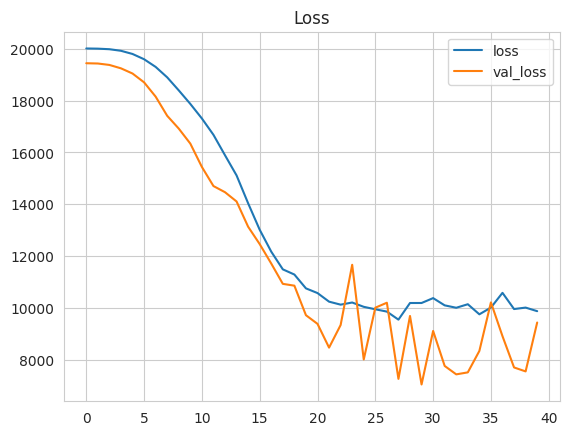

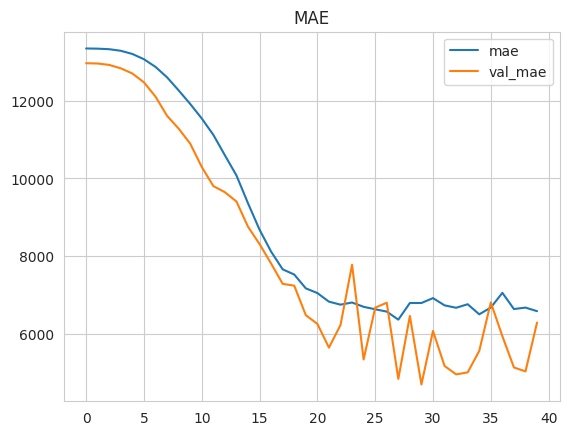

In [ ]:
model_keras = fit_keras_model(X_val, y_val)
# Save the model
model_keras.save('model_keras.h5')


In [ ]:
model_score(X_val, y_val, model_keras)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MAE: 4691.84
MSE: 64193014.51
RMSE: 8012.05
R2: 0.59


# Now try using tree-based model

In [ ]:
# Now try using tree-based model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb_model = fit_model(X_train, y_train, model=xgb_model)
y_pred = xgb_model.predict(X_val)
# y_pred = np.expm1(y_pred_log)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

# Save model
joblib.dump(xgb_model, 'xgbmodel.pkl')

MAE: 2377.62
MSE: 20371066.34
RMSE: 4513.43
R2: 0.87


['xgbmodel.pkl']

In [ ]:
!ls /content

data   linearmodel.pkl	preprocessor.pkl  xgbmodel.pkl
drive  model_keras.h5	sample_data
